<a href="https://colab.research.google.com/github/Clarke-Jools-36/GWAstro/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Analysis of GW190521

For this assignment, you will have to conduct an analysis of the gravitational-wave signal GW190521. This analysis should be done within a Jupyter notebook, with many comments in [Markdown](https://colab.research.google.com/notebooks/markdown_guide.ipynb) desribing and **justifying** the steps taken.

- The writing should be at the level of a fellow student of the class
- Submit **both** the .ipybn file and the converted .pdf file:
  - submit the .pdf file to TurnitIn (make sure all the cells have been run).
  - and the .ipynb file by e-mail with the subject "PXT903/PX4236 Final Project"
- Describe **in details** every step of your analysis throughout the notebook.
- Any setting choice (sampling rate, window parameter, FFT length, etc...) needs to be justified, either by its own investigation or relevant citations from the literature.
- Code alone, without a detailed descriptions of what is done and why, is worth half marks at the most.

NOTE: you can use any of the notebooks covered in the class, or code available online, _provided that you justify the settings and methods used_.

## Introduction (15 points)
Minimum 300 words.
- Write an introduction to this analysis, citing the relevant context and literature.
- Write a short summary of what is done in the notebook.

GW190521 (initially **S190521g**) is a GW caused by a black hole merger which was, when occurred mid 2019, the largest mass event ever recorded by LIGO and Virgo. It has a possible EM counterpar
t [Graham 2020], which would make this the first EM BH merger emission. The masses of the two objects are 85 solar masses and 66 solar masses. 9 solar masses worth of energy was radiated away as GW emission leaving a remnant of 142 solar masses [Abbott 2020a]. 

This analysis will fit CBC and Gauss Pulse templates to the GW data in order to constrain the parameters of the event. Initially I will compute a power spectrum density and whiten the data based on individual detector data. This whitened data will allow for the GW event to be seen. I will also apply a bandpass filter to hylight the wave. Both CBC and Gauss Pulse templates will be produced, and then these will be fitted to the data manually as a prior guess at the parameters. I will explore possible parameter values within literature and base my guess around these, adjusting them to fit the signal if neccessary. 

From here I will compute SNR for the signal and templates with time. This allows the point at which the GW takes place in each detector to be identified. Note that these are not the same, nor are they the same as the reported GPS time of the event, as this is the time at whichethe waves passes through the center of the earth. I will compute the local event times for each detector site and then I will adjust the models to acount for this considering the network as a whole. This allows for sky localisation data to be identified from three detectors via triangulation. 

I will take likelihood prior and posterior data taking into account the network, and then sample the probability density function using monte carlo markov chains. I will conduct this analysis for buth the gauss pulse and CBC templates in order to make comparisons about the two. 

344 words


## The data and noise model (10 points)

- Download and plot the relevant gravitational-wave data for GW190521.
- Compute and plot the Power Spectrum Density.
- Compute and plot the whitened data. Use filters if necessary to best highlight where the signal is (or might be).

First I will import `pyplot` in order to visualise the data, and `numpy` to handle arrays. I also need the `gwpy` module to access `gwosc.datasets`, which is a tool that allows me to access data releases and GW catalogues such as GWTC-1. I will keep this in a seperate cell so it only has to be run once. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

! pip install -q gwpy
from gwosc.datasets import event_gps

GW timing is described using GPS time. This is a measure of time in seconds which does not account for leap seconds, so is much better for continuous experiments like GW observing runs. To get the GPS time of the GW190521 (initially **S190521g**) we use the `event_gps` function. We can convert from GPS to calendar time using `from_gps`

In [2]:
from gwpy.time import from_gps

gps = event_gps('GW190521')

print(f"The GPS time is: {gps} seconds")
print(f"The calendar date is {from_gps(gps)}")

The GPS time is: 1242442967.4 seconds
The calendar date is 2019-05-21 03:02:29.400000


We can use the GPS time to retrieve the strain data for the event using `fetch_open_data`. We can get data for Livingston, Hanford and Virgo detectors. This might take a while so should only run once. I'm going to capture 64 seconds of data either side of the event gps time in order to ensure that I have contained the entire event. I will trim this down later to a more reasonable value once I have plotted the graphs.

In [3]:
from gwpy.timeseries import TimeSeries

segment_length = 64 #seconds
segment = (int(gps)-(segment_length/2), int(gps)+(segment_length/2))

data={} # an empty dictionary
ifos=['L1','V1','H1'] # a list which we use as the dictionary keys
for ifo in ifos:
    data[ifo] = TimeSeries.fetch_open_data(ifo, *segment) 



I can plot the data using pyplot, using the specific colours assigned to the GW observatories for clarity. The event occurs at the point marked by the dotted vertical line

/usr/local/lib/python3.9/dist-packages/gwpy/plot/axes.py:187: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  super().draw(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


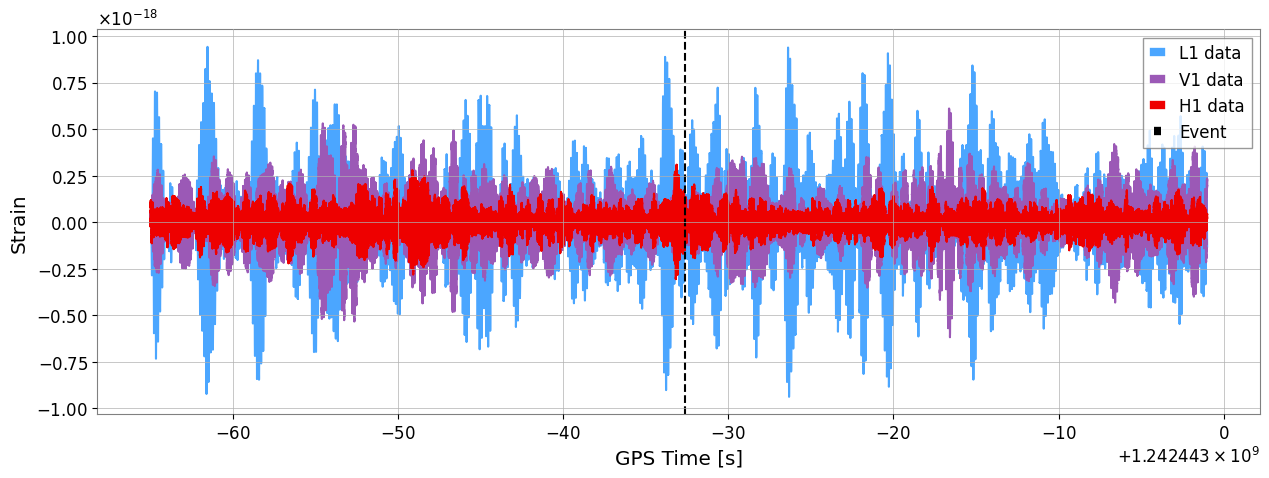

In [4]:
plt.figure(figsize=(15,5))
colours=['gwpy:ligo-livingston','gwpy:virgo','gwpy:ligo-hanford'] #define colours to use

for ifo,colour in zip(ifos,colours):
  plt.plot(data[ifo].times,data[ifo],label=f'{ifo} data',color=colour)

plt.axvline(gps, linestyle="--", color='k', label="Event")
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend()
plt.show()

I will plot the spectral density of the whole segment. This is done using a fast fourier transform. It makes the assumption that the component frequencies present are time inveriant so it will give a rough noise profile of the three detectors. I will make a cutoff at anything below 10hz as there is not long enough data range in order to accurately assess these frequencies, and above 1khz as this is the maximum I can calculate based on the sample rate of the data. In order to mitigate edge effects, a window function needs to be applied. This slowly reduces the strain at the endes of the sample, to stop the fourier transform picking up on the harsh cutoff at the edge of the dataset. The window length is set to 2 as this is a good trade off between frequency resolution and power resolution.

[]

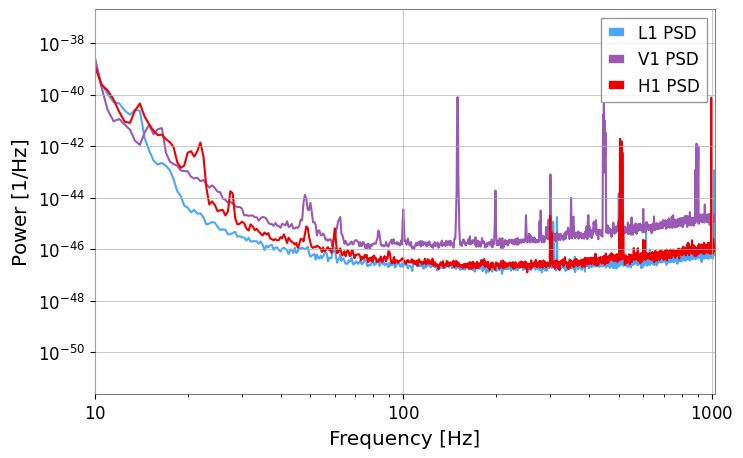

In [5]:
window_l = 2
psd_ = {}
for ifo in ifos:
  psd_[ifo]=(data[ifo].psd(fftlength=window_l))

plt.figure(figsize=(8,5))
for ifo,colour in zip(ifos,colours):
  plt.loglog(psd_[ifo].frequencies,psd_[ifo],label=f'{ifo} PSD',color=colour)


plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [$1/\mathrm{Hz}$]')
plt.xlim(10,1024)
plt.legend()
plt.plot()

Now I can apply whitening to the data in order to flatten out the predictable noise structure. THis uses the PSD to identify the underlying noise structure and then corrects for this. 

In [6]:
white_ = {}
for ifo in ifos:
  white_[ifo] = data[ifo].whiten(fftlength=window_l)

I can then bandpass the data using the built in `bandpass` function, which removes frequencies outside of the range we are interested in. From the psd graph above I choose a minimum of 40 hz, to remove the increase in noise at the low end. Knowing the length of a typical GW is in the order of magnitude of 1 second, I chose the upper limit of 120Hz, because any wave components above this are going to be oscillating 420 times in the 4 second segment i am going to select, too quickly to add detail to the graph.

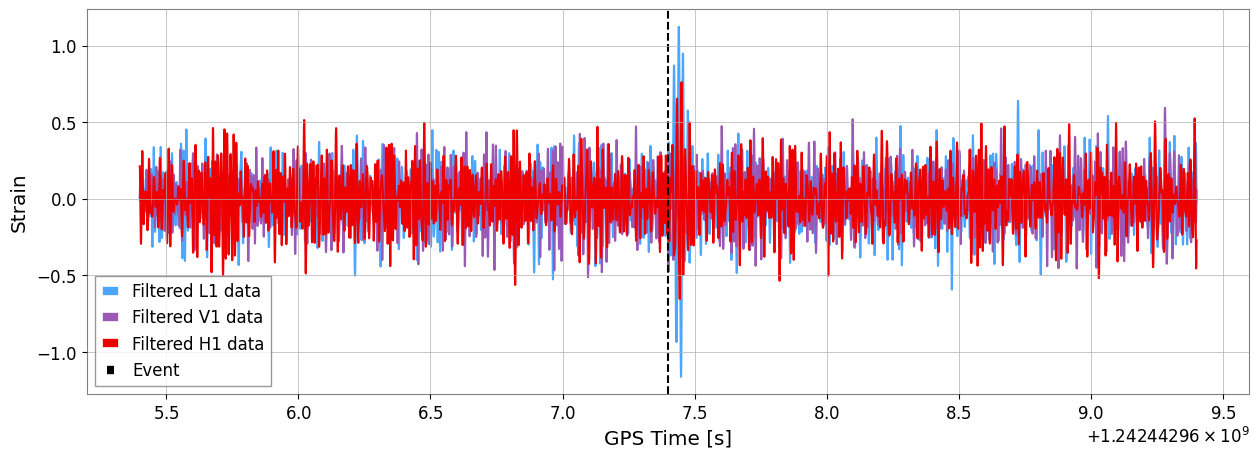

In [7]:
bp_ = {}

for ifo in ifos:
  bp_[ifo]=white_[ifo].bandpass(40,120).crop(gps-2,gps+2)

plt.figure(figsize=(15,5))
for ifo,colour in zip(ifos,colours):
  plt.plot(bp_[ifo].times,bp_[ifo],label=f'Filtered {ifo} data', color=colour)

plt.axvline(gps, linestyle="--", color='k', label="Event")
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend()
plt.show()

THis is a bit too much data, so lets zoom in around the event mark in order to get some more detail. I know there should be more inspiral data before the event, and after the event will return back to normal so lets take 0.3 seconds before and 0.2 seconds aftere the event GPS time

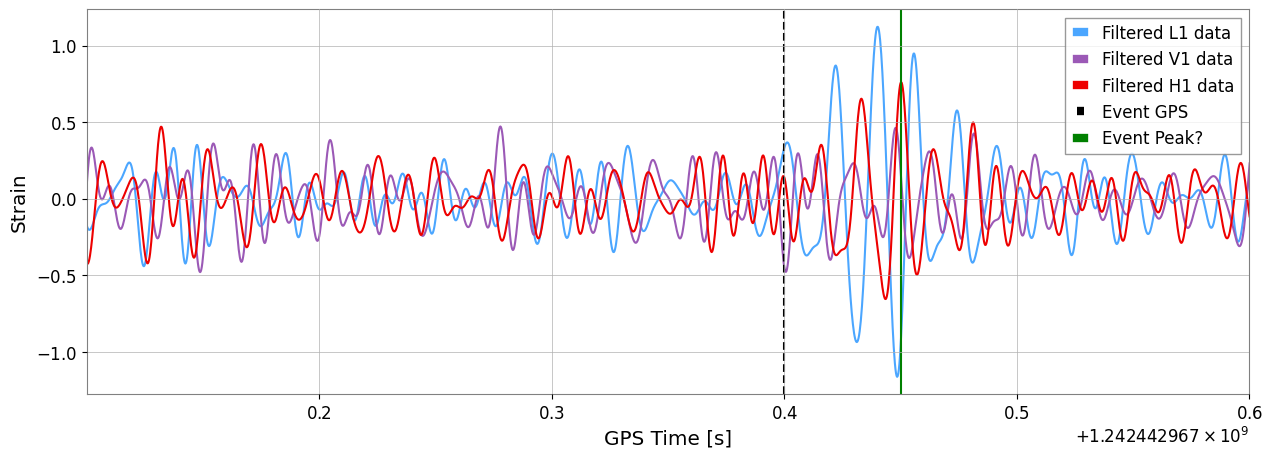

In [8]:
plt.figure(figsize=(15,5))

for ifo,colour in zip(ifos,colours):
  plt.plot(bp_[ifo].times,bp_[ifo],label=f'Filtered {ifo} data', color=colour)
plt.axvline(gps, linestyle="--", color='k', label="Event GPS")
plt.axvline(gps+0.05, linestyle="-", color='green', label="Event Peak?")
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.xlim(gps-0.3,gps+0.2)
plt.legend()

The reported GPS time (dashed) does not look like it is lining up with the event at this resolution, but the event is clearly visible at the green line. This is due to the GPS time being a report of when the GW travels through the center of the earth. Because of the different locations of the detectors, the event peak occurs at different times locally for all three detectors. 

## The signal model (10 points)

- Generate and plot a CBC signal which you expect to be a good match for the signal. Use the literature, and cite your sources
- Generate and plot a phenomenological model (sometimes refer to as a "Burst" model). A model whose parameters describe the shape of the waveform itself, not the source. 
- Compute the overlap between those those two signals, and try to find parameters that maximises that overlap.

NOTE: remember that gravitational-wave are redshifted.

In order to generate a CBC signal we will use `pycbc` so first lets install it and import the required functions.


In [9]:
! pip install -q lalsuite pycbc
from pycbc.waveform import get_td_waveform

CBC assumes the source of the gravitational wave, so lets get some papers to back up the assumption that this was a binary merger event. I will draw data from two different papers by the LIGO collaboration, the first of which places constrains on the masses of the objects involved in the merger and the second of which constrains the redshift. 

redshift = 0.8

m1 = 85+21-14 M_sol

m2 = 66+17-18 M_sol

m remnant = 142+28-16 M_sol

f_0 = 11Hz

[Abbott 2020a]

redshift = 0.82+0.28-0.34

luminousity distance = 5.3+2.4-2.6 Gpc

[Abbott 2020b]

In [10]:
m1 = 85 # Solar masses
m2 = 66 # Solar masses
z = 0.82
f_0 = 11 #Hz

d = 5.3E3 #Mpc (from redshift)

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m1,
                         mass2=m2,
                         distance=d,
                         delta_t=1./4096.,#timestep
                         f_lower=f_0)

In [11]:
print(hp)

[-1.05163915e-22 -1.04632331e-22 -1.04070785e-22 ...
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00]


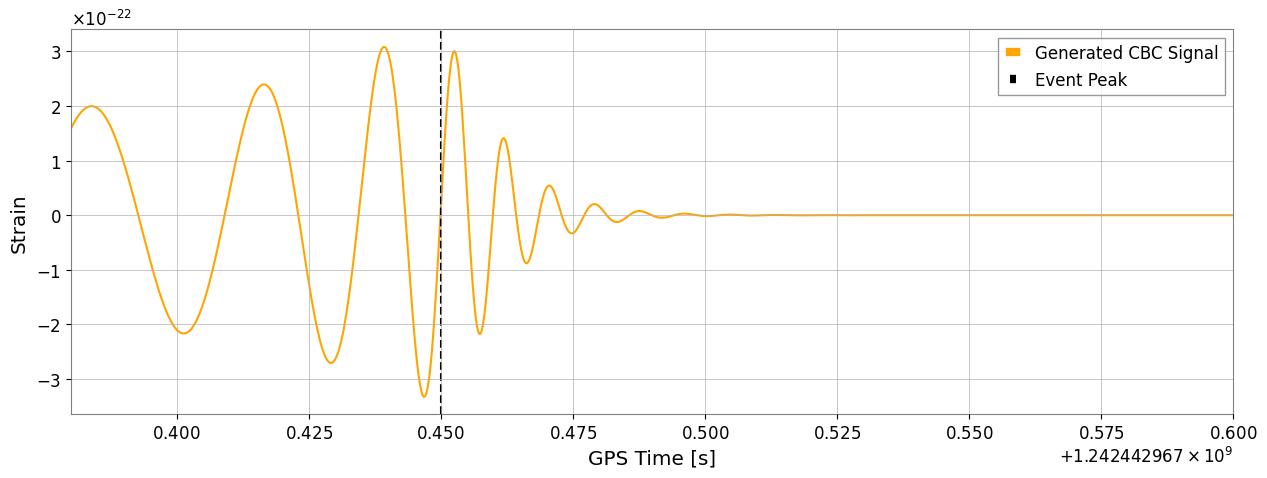

In [12]:
fig, ax1 = plt.subplots(figsize=(15,5))

plt.plot(hp.sample_times+gps+0.05,hp,label='Generated CBC Signal', color='orange')

plt.axvline(gps+0.05, linestyle="--", color='k', label="Event Peak")
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.xlim(gps-0.02,gps+0.2)
plt.legend()


If I dont make assumptions about the source of the data, I can still attempt to generate a model for the data. I will do this by using a sin-gaussian signal.

for some reason this cell will fail first time round, but restarting the kernel and running agin fixes it. It doesnt make that much sense but it's something to do with importing the packages with `!pip` requires a restart.

In [13]:
from scipy.signal import gausspulse
#arbitrary values but we will ttune these later in order to maximise overlap
freq_center = 80#Hz 
fract_bw = 0.3
max_strain = max(hp)

#     because of the horrible nature of multiple different standards, when we generate GP, 
#     it needs to be converted to a gwpy timeseries
gp_numpy = gausspulse(hp.sample_times, fc=freq_center, bw=fract_bw)*max_strain
gp_gwpy = TimeSeries(gp_numpy, dt=hp.delta_t, t0=hp.start_time)
gp=gp_gwpy.to_pycbc()
type(gp)

pycbc.types.timeseries.TimeSeries

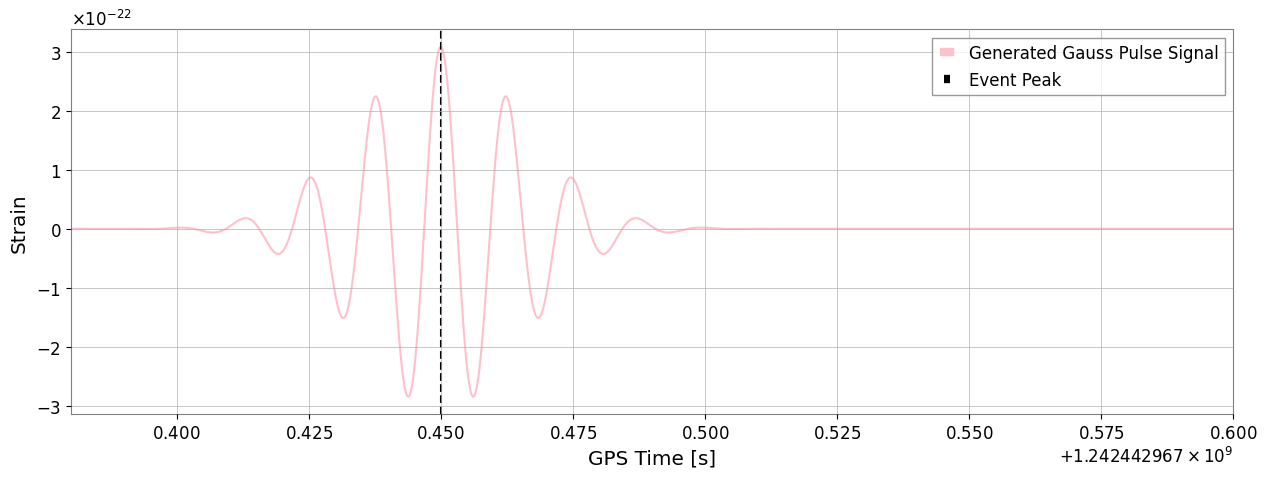

In [14]:
fig, ax1 = plt.subplots(figsize=(15,5))
plt.plot(gp.sample_times+gps+0.05,gp,label='Generated Gauss Pulse Signal', color='pink')

plt.axvline(gps+0.05, linestyle="--", color='k', label="Event Peak")
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.xlim(gps-0.02,gps+0.2)
plt.legend()


this is a pycbc error again no?

```

Pxx=hp.psd(fftlength=4.,window=('tukey',1./4.),method='welch',overlap=2.)

# We will need the PSD with the same frequency spacing as the data and template,
# so we interpolate it to match:
Pxx_32=Pxx.interpolate(hp.df.value)

# This is equation 7.49 of the textbook: the overlap of the template with itself
sigmasq = 4 * np.real((gp* gp.conjugate() / Pxx_32).sum() * gp.df)
sigma = np.sqrt(np.abs(sigmasq))

```



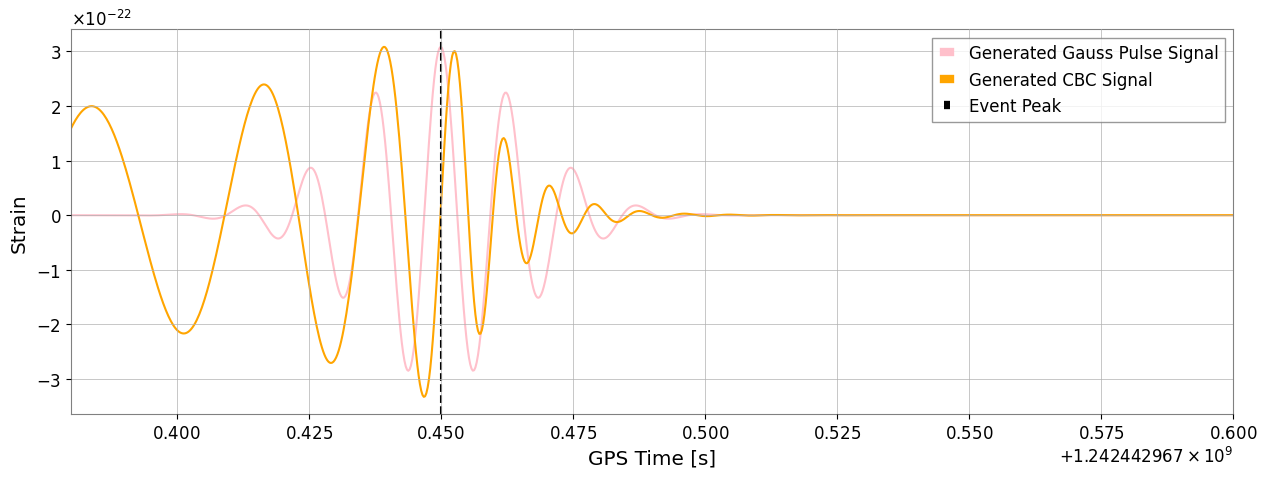

In [15]:
fig, ax1 = plt.subplots(figsize=(15,5))
plt.plot(hp.sample_times+gps+0.05,gp,label='Generated Gauss Pulse Signal', color='pink')
plt.plot(hp.sample_times+gps+0.05,hp,label='Generated CBC Signal', color='orange')
plt.axvline(gps+0.05, linestyle="--", color='k', label="Event Peak")
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.xlim(gps-0.02,gps+0.2)
plt.legend()


## Detection (25 points)
Limiting yourself to a coincident (**not** coherent) analysis:
- Compute the SNR time series for the CBC signal model
- Compute the SNR time series for the Burst signal model
- Discuss the differences, if any.
- Estimate a bound on the False Alarm Rate of the detection.

Lets first compare the SNR with the CBC model. In order to make it neater to do this for all three detectors I will create a short function which takes the detector and model timeseries, and outputs the SNR time series

In [16]:
def compute_snr_timeseries(detector_data, model_data, gps_t):
  
  Pxx_H1=detector_data.psd(fftlength=4.,window=('tukey',1./4.),method='welch',overlap=2.)

  # Making the reference signal 32 seconds:
  model_data.prepend_zeros(np.ceil((16+model_data.start_time)/model_data.delta_t))
  model_data.append_zeros(np.floor((16-model_data.end_time)/model_data.delta_t))

  template=TimeSeries.from_pycbc(model_data)
  template.duration

  # Same with the data:
  strain_H1_32=detector_data.crop(gps_t - 16,gps_t + 16)


  # FFT of the data, with the appropriate normalisation
  data_f=strain_H1_32.average_fft(window=('tukey',1./4.))*(strain_H1_32.duration/2)

  # FFT of the template, with the appropriate normalisation
  template_f=template.average_fft(window=('tukey',1./4.))*(template.duration/2)

  # We will need the PSD with the same frequency spacing as the data and template,
  # so we interpolate it to match:
  Pxx_H1_32=Pxx_H1.interpolate(data_f.df.value)

  # With the right normalisation, this is equation 7.58 of the textbook:
  optimal=data_f*template_f.conjugate()/Pxx_H1_32
  opt_time=2*optimal.ifft()*(optimal.df*2)

  # This is equation 7.49 of the textbook: the overlap of the template with itself
  sigmasq = 4 * np.real((template_f * template_f.conjugate() / Pxx_H1_32).sum() * template_f.df)
  sigma = np.sqrt(np.abs(sigmasq))

  # And now we have the SNR time series:
  SNR_complex = opt_time/sigma

  # We can recenter thing with the location of peak in the template:
  peaksample = template.argmax()  
  SNR_complex = np.roll(SNR_complex,peaksample)
  SNR = abs(SNR_complex)

  SNRmax=SNR.max().value
  time_max=SNR.times[SNR.argmax()]
  print(f'Maximum SNR of {SNRmax:.4f} at {(time_max.value-1.2424429E9):.2f} + 1.2424429e+9')
  return SNR

Lets now apply this to all three detectors

In [17]:
print(data[ifos[0]])

TimeSeries([ 9.79126568e-20,  9.77894386e-20,  9.68162175e-20,
            ..., -1.28180966e-19, -1.31589955e-19,
            -1.31979429e-19]
           unit: dimensionless,
           t0: 1242442935.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


In [18]:
snr_ = {}
for ifo in ifos:
  snr_[ifo] = compute_snr_timeseries(data[ifo],hp,gps)

Maximum SNR of 9.4857 at 67.44 + 1.2424429e+9
Maximum SNR of 5.2634 at 64.19 + 1.2424429e+9
Maximum SNR of 7.1448 at 67.44 + 1.2424429e+9


We can see from the maximum SNR time that the SNR for virgo does not line up with the other two sites, lets plot the SNRs and confirm this

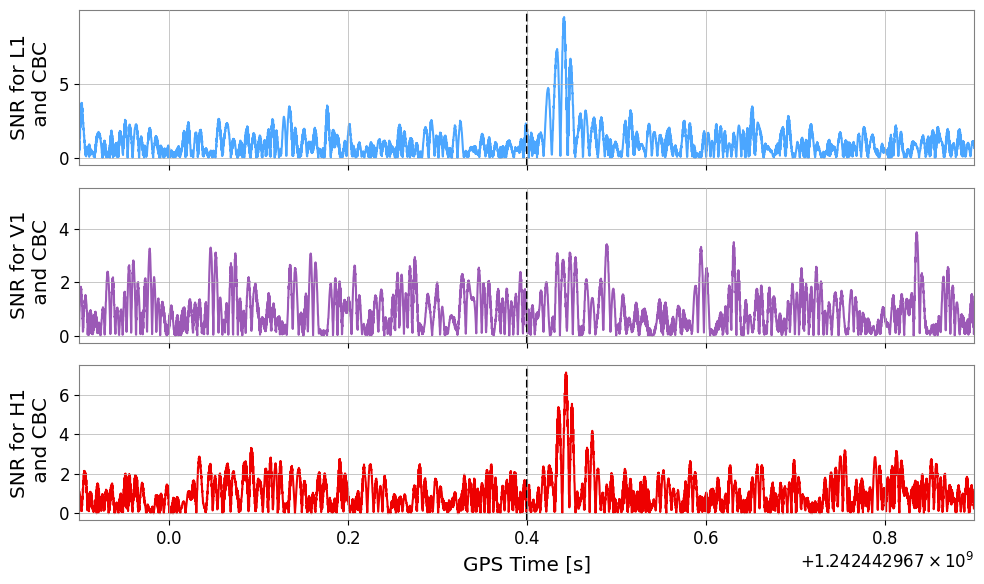

In [19]:
fig, axs = plt.subplots(len(ifos),1,figsize=(10,6))

for i,(ifo,colour) in enumerate(zip(ifos,colours)):
  axs[i].plot(snr_[ifo].times,snr_[ifo],label=f'SNR for {ifo} and CBC', color=colour)
  axs[i].axvline(gps, linestyle="--", color='k', label="Event Peak")
  axs[i].set_ylabel(f'SNR for {ifo}\n and CBC')
  axs[i].set_xlim(gps-0.5,gps+0.5)
  axs[i].tick_params('x', labelbottom=False)

plt.xlabel('GPS Time [s]')

plt.tick_params('x', labelbottom=True)
plt.tight_layout()

There is strong SNR for the two LIGO sites, but not Virgo

Now lets do the same for the Gauss Pulse 

In [20]:
snr_gp_ = {}

for ifo in ifos:
  snr_gp_[ifo] = compute_snr_timeseries(data[ifo],gp,gps)

Maximum SNR of 6.0957 at 73.80 + 1.2424429e+9
Maximum SNR of 4.7011 at 64.20 + 1.2424429e+9
Maximum SNR of 4.6642 at 57.67 + 1.2424429e+9


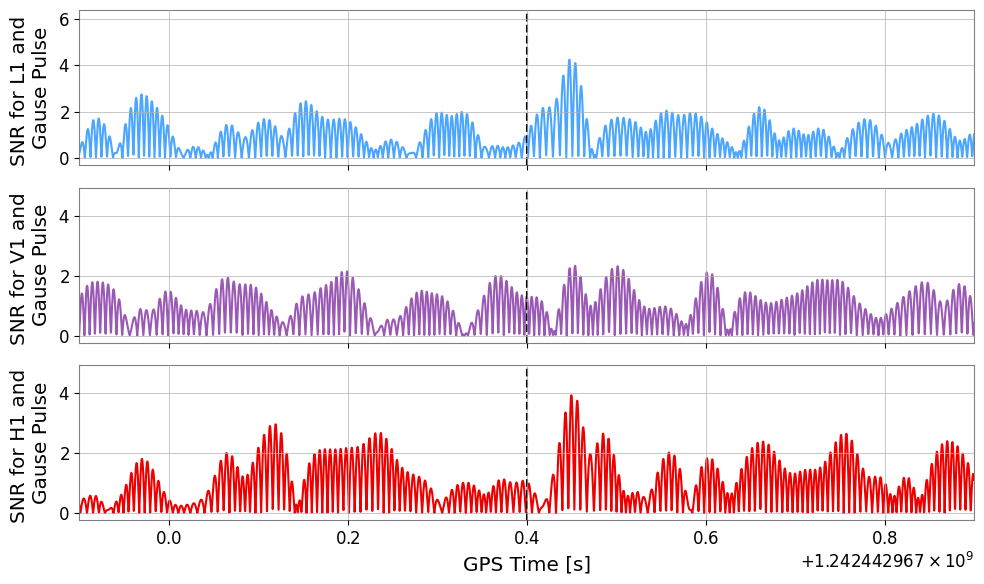

In [21]:
fig, axs = plt.subplots(len(ifos),1,figsize=(10,6))

for i,(ifo,colour) in enumerate(zip(ifos,colours)):
  axs[i].plot(snr_gp_[ifo].times,snr_gp_[ifo],label=f'SNR for {ifo} and Gause Pulse', color=colour)
  axs[i].axvline(gps, linestyle="--", color='k', label="Event Peak")
  axs[i].set_ylabel(f'SNR for {ifo} and \nGause Pulse')
  axs[i].set_xlim(gps-0.5,gps+0.5)
  axs[i].tick_params('x', labelbottom=False)


plt.xlabel('GPS Time [s]')

plt.tick_params('x', labelbottom=True)
plt.tight_layout()

Now lets estimate a FAR (false alarm rate) bound. 


## Parameter Estimation (25 points)
Moving to a **coherent** analysis:
- Using the CBC model, build a likelihood, prior and posterior function for the network of gravitational-wave detectors.
- Maximise that function and plot the relevant quantities.
- Interface that posterior function with a sampling algorithm (you are free to select any ready-made algorithm).
- Perform the sampling, and plot the results.
- Redo the steps above with the Burst model.
- Compare the results and discuss.

In order to conduct a coherent analysis we need to take into account the network of detectors as a linked system. Lets import the `pycbc.detector` function to retrieve detector information

In [22]:
from pycbc.detector import Detector
# Creating the detector objects:
det={}
for ifo in ifos:
    det[ifo]=Detector(ifo)

We will start with a rough approximation of the sky localisation of the GW signal. From literature sources the RA of the corresponding EM signal was 12h49m42.3s and the dec was -34°49'29" [Graham 2020]

I am assuming no polarisation unless i come across a literature source to the contrary.



In [23]:
declination = -34 +( (1/60) * 49)+( (1/(60*60)) * 29 )
right_ascension = ( (360/24) * 12 )+( (360/(24*60)) * 49 )+( (360/(24*60*60)) * 42.3 )
polarization = 0.0

fp={}
fc={} 
for ifo in ifos:
    fp[ifo], fc[ifo] = det[ifo].antenna_pattern(right_ascension, declination, polarization, gps)
    print(f"{ifo}: fp={fp[ifo]:.4f}, fc={fc[ifo]:.4f}")

L1: fp=0.6022, fc=-0.2796
V1: fp=0.0303, fc=-0.7301
H1: fp=-0.5838, fc=0.5126


THe reported GPS time of the event is actually the time at which the GW passes through the center of the earth. Because of the different positions of the three detectors, they will experience the GW at slightly different times. We can compute the times by using the `pycbc` `time_delay_from_earth_center` function. 

In [24]:
gps_diff = {}
gps_det = {}

for ifo in ifos:
  gps_diff[ifo]=det[ifo].time_delay_from_earth_center(right_ascension, declination, gps)
  gps_det[ifo] = gps + gps_diff[ifo]

  print(f"""
For the sky-position ra={right_ascension:.4f},dec={declination:.4f}, at time={gps}, the
time delay between {ifo} and the geocenter is {gps_diff[ifo]} seconds
meaning that the event occurs at {gps_det[ifo]} locally\n""")

  


For the sky-position ra=192.4263,dec=-33.1753, at time=1242442967.4, the
time delay between L1 and the geocenter is 0.013482614874032527 seconds
meaning that the event occurs at 1242442967.4134827 locally


For the sky-position ra=192.4263,dec=-33.1753, at time=1242442967.4, the
time delay between V1 and the geocenter is 0.0153638407166291 seconds
meaning that the event occurs at 1242442967.415364 locally


For the sky-position ra=192.4263,dec=-33.1753, at time=1242442967.4, the
time delay between H1 and the geocenter is 0.016427725900472 seconds
meaning that the event occurs at 1242442967.4164279 locally



Lets use this information to build a function which generates more accurate CBC waveforms

In [27]:
def gen_template(param,
                 duration=data['H1'].duration.value, # Assuming all IFOs have the same duration !
                 start_time=data['H1'].x0.value,# Assuming all IFOs have the same start time !
                 delta_t=data['H1'].dt.value, # Assuming all IFOs have the same dt !
                 f_lower=f_0):
    
    m1, m2, distance, time, phase, right_ascension, declination, inclination, polarization = param

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m1,
                             mass2=m2,
                             distance=distance,
                             inclination=inclination,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower) 
    
    # Resize the signal buffer
    hp.resize(int(duration/delta_t))
    hc.resize(int(duration/delta_t))
    
    ht={}
    template={}
    # compute the detectors responses and shift to the requested time
    for ifo in ifos:
        fp, fc = det[ifo].antenna_pattern(right_ascension, declination, polarization, time)
        ht[ifo] = fp * hp.copy() + fc * hc.copy()
        
        time_delay = det[ifo].time_delay_from_earth_center(right_ascension, declination, time)
        
        ht[ifo] = ht[ifo].cyclic_time_shift(ht[ifo].start_time + time - start_time + time_delay)
        ht[ifo].start_time=start_time
    
        template[ifo]=TimeSeries.from_pycbc(ht[ifo])
    return template

If we apply the coefficients from the literature to this fucntion we can generate a template for each detector and how they would observe the event. 

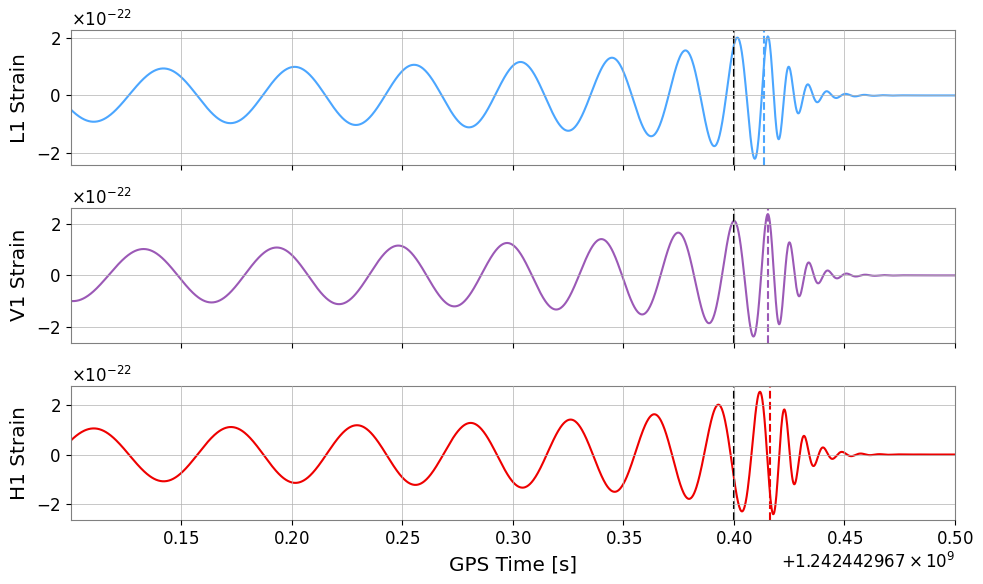

In [28]:
phase=0
param=[m1, m2, d, gps, phase, right_ascension, declination, 0.1, polarization]
# m1, m2, distance, time, phase, right_ascension, declination, inclination, polarization
template=gen_template(param, duration=data['H1'].duration.value, start_time=data['H1'].x0.value)

fig, axs = plt.subplots(len(ifos),1,figsize=(10,6))

for i,(ifo,colour) in enumerate(zip(ifos,colours)):

  axs[i].plot(template[ifo],label='{} signal'.format(ifo),color=colour)
  axs[i].axvline(gps, linestyle="--", color='k', label="Geocenter Time of Event")
  axs[i].axvline(gps_det[ifo], linestyle="--", color=colour, label="Local Time of Event")
  axs[i].set_ylabel(f'{ifo} Strain')
  axs[i].set_xlim(gps-0.3,gps+0.1)
  axs[i].tick_params('x', labelbottom=False)


plt.xlabel('GPS Time [s]')

plt.tick_params('x', labelbottom=True)
plt.tight_layout()

for this analysis, we don't need to use as much data as we initially downlaoded. Now we are confident about the positioning and length of the event we can crop out everything except for a short 4 second section around the event. 

In [29]:
type(data['H1'])

gwpy.timeseries.timeseries.TimeSeries

In [30]:
for ifo in ifos:
    data[ifo]=data[ifo].crop(gps-1,gps+1)

In [32]:
psd={}
for ifo in ifos:
    psd[ifo] = data[ifo].psd(fftlength=2)

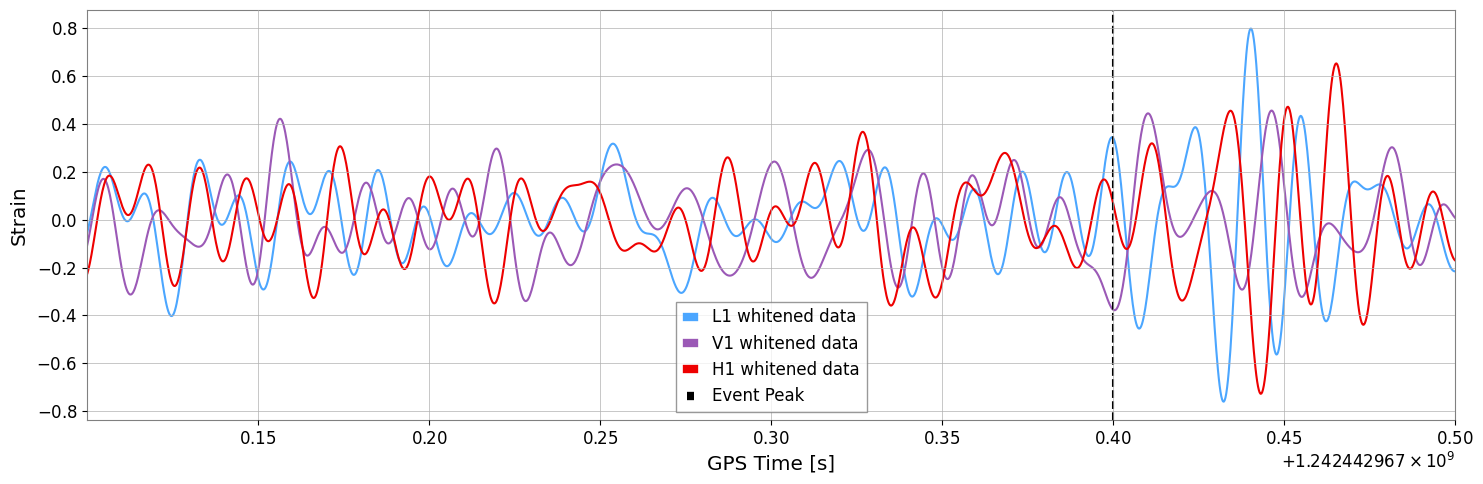

In [34]:
plt.figure(figsize=(15,5))

white_data={}
for ifo,colour in zip(ifos,colours):
    white_data[ifo]=data[ifo].whiten(fftlength=2).bandpass(f_0,80)
    plt.plot(white_data[ifo],label=f'{ifo} whitened data',color=colour)
plt.xlim(gps-0.3,gps+0.1)
plt.axvline(gps, linestyle="--", color='k', label="Event Peak")
plt.ylabel('Strain')
plt.xlabel('GPS Time [s]')
plt.legend()
plt.tight_layout()


Then we will construct a likelihood. In order to construct the likelihood for the 3 detectors we first assume that noise is independent between all three

In [35]:
# FFT the data
sf={}
for ifo in ifos:
    sf[ifo] = data[ifo].average_fft(window=('tukey',1./4.))*data[ifo].duration.value/2

def loglikelihood(param, sf=sf, f_lower=f_0):
    logl=0.0    
    template = gen_template(param, delta_t=data['H1'].dt.value ,f_lower=f_lower) #all the delta t values are the same for all detectors so this is arbitrary
    for ifo in ifos:
        # zero out the frequencies below f_lower
        sf_hp = sf[ifo].crop(start=f_lower)
        psd_hp = psd[ifo].crop(start=f_lower)
        hf = template[ifo].average_fft(window=('tukey',1./4.))*template[ifo].duration.value/2
        hf_hp = hf.crop(start=f_lower)
##
        # hf_hp, hf_hp.conjugate(), psd_hp go into failing line
        if debug_: print(f'hf_hp: {len(hf_hp)}')
        if debug_: print(f'hf_hp.conjugate(): {len(hf_hp.conjugate())}')
        if debug_: print(f'psd_hp: {len(psd_hp)}')
        if debug_: print(f'> psd[ifo]: {len(psd[ifo])}') #this goes into psd_hp

        if debug_: print(len(hf.crop(start=f_lower))  ==  len(psd[ifo].crop(start=f_lower))) #this needs to be true, but ITS GEN TEMPLATE using the wrong vbersion of data that hasnt been time cropped to 4 sec? 

        h_dot_h  = 4 * np.real((hf_hp * hf_hp.conjugate() / psd_hp).sum() * hf_hp.df) #THIS IS THE ISSUE <PSD_HP>!!<<

        if debug_: print('test inject success')
##
        h_dot_s  = 4 * np.real((sf_hp * hf_hp.conjugate() / psd_hp).sum() * sf_hp.df)
        logl += h_dot_s - h_dot_h/2
    return logl.value

Lets choose some ballpark values and input these. I will be using the values from literature.

In [36]:
# m1, m2, distance, time, phase, right_ascension, declination, inclination, polarization
param0=[m1, m2, d, gps, phase, right_ascension, declination, 0.1, polarization]

template0 = gen_template(param0, duration=data['H1'].duration.value, start_time=data['H1'].x0.value)

Here I test the loglikelihood() function, check the cell above for where the function is defined and see my debugging statements. I need to make the two arrays the same length, and this is the fault of my gen template function using the wrong global variables I think, but then I loose the trail and I'm not sure what to try next. Do i need to modify gen template in any way? I thought it would take the current value of global data which is cropped to 4 seconds after gen template is defined but that doesnt seem to be the case. 

UPDATE: if i redefine gentemplate here then it works...?

In [37]:
def gen_template(param,
                 duration=data['H1'].duration.value, # Assuming all IFOs have the same duration !
                 start_time=data['H1'].x0.value,# Assuming all IFOs have the same start time !
                 delta_t=data['H1'].dt.value, # Assuming all IFOs have the same dt !
                 f_lower=f_0):
    
    m1, m2, distance, time, phase, right_ascension, declination, inclination, polarization = param

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m1,
                             mass2=m2,
                             distance=distance,
                             inclination=inclination,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower) 
    
    # Resize the signal buffer
    hp.resize(int(duration/delta_t))
    hc.resize(int(duration/delta_t))
    
    ht={}
    template={}
    # compute the detectors responses and shift to the requested time
    for ifo in ifos:
        fp, fc = det[ifo].antenna_pattern(right_ascension, declination, polarization, time)
        ht[ifo] = fp * hp.copy() + fc * hc.copy()
        
        time_delay = det[ifo].time_delay_from_earth_center(right_ascension, declination, time)
        
        ht[ifo] = ht[ifo].cyclic_time_shift(ht[ifo].start_time + time - start_time + time_delay)
        ht[ifo].start_time=start_time
    
        template[ifo]=TimeSeries.from_pycbc(ht[ifo])
        if debug_: print(f'(inside gen_template) template[{ifo}]: {len(template[ifo])}')
    return template

In [38]:
debug_=True
print(loglikelihood(param))
debug_=False

(inside gen_template) template[L1]: 8192
(inside gen_template) template[V1]: 8192
(inside gen_template) template[H1]: 8192
hf_hp: 4075
hf_hp.conjugate(): 4075
psd_hp: 4075
> psd[ifo]: 4097
True
test inject success
hf_hp: 4075
hf_hp.conjugate(): 4075
psd_hp: 4075
> psd[ifo]: 4097
True
test inject success
hf_hp: 4075
hf_hp.conjugate(): 4075
psd_hp: 4075
> psd[ifo]: 4097
True
test inject success


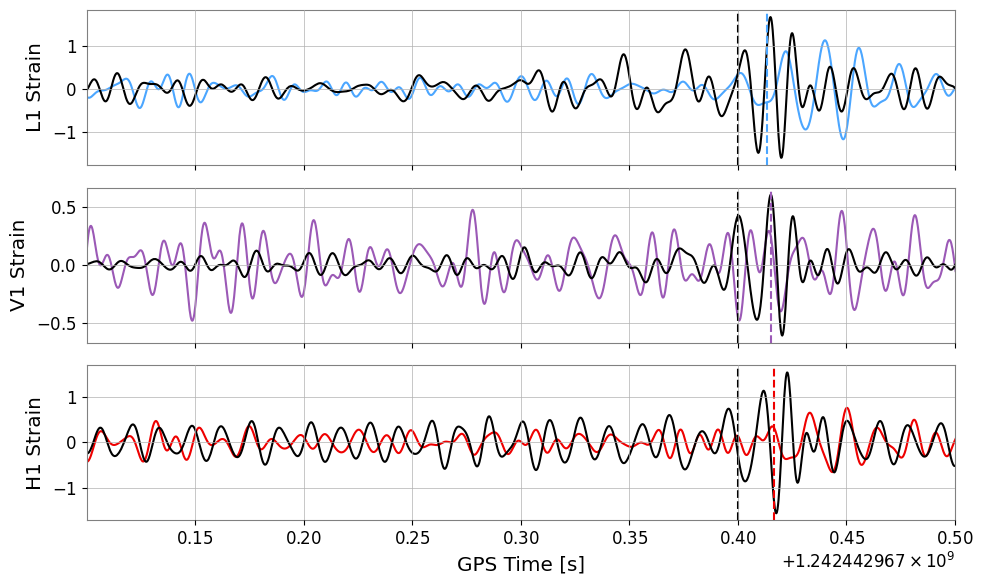

In [39]:
fig, axs = plt.subplots(len(ifos),1,figsize=(10,6))

for i,(ifo,colour) in enumerate(zip(ifos,colours)):
  white_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=f_0)

  axs[i].plot(bp_[ifo].times, bp_[ifo], color=colour)
  axs[i].plot(white_template.times, white_template, label="CBC Template",color='k')
  axs[i].axvline(gps_det[ifo], linestyle="--", color=colour, label="Local Time of Event")
  axs[i].axvline(gps, linestyle="--", color='k', label="Event Peak")
  axs[i].set_ylabel(f'{ifo} Strain')
  axs[i].set_xlim(gps-0.3,gps+0.1)
  axs[i].tick_params('x', labelbottom=False)


plt.xlabel('GPS Time [s]')
#plt.legend()
plt.tick_params('x', labelbottom=True)
plt.tight_layout()

this fails because interpolation is wrong somewhere...

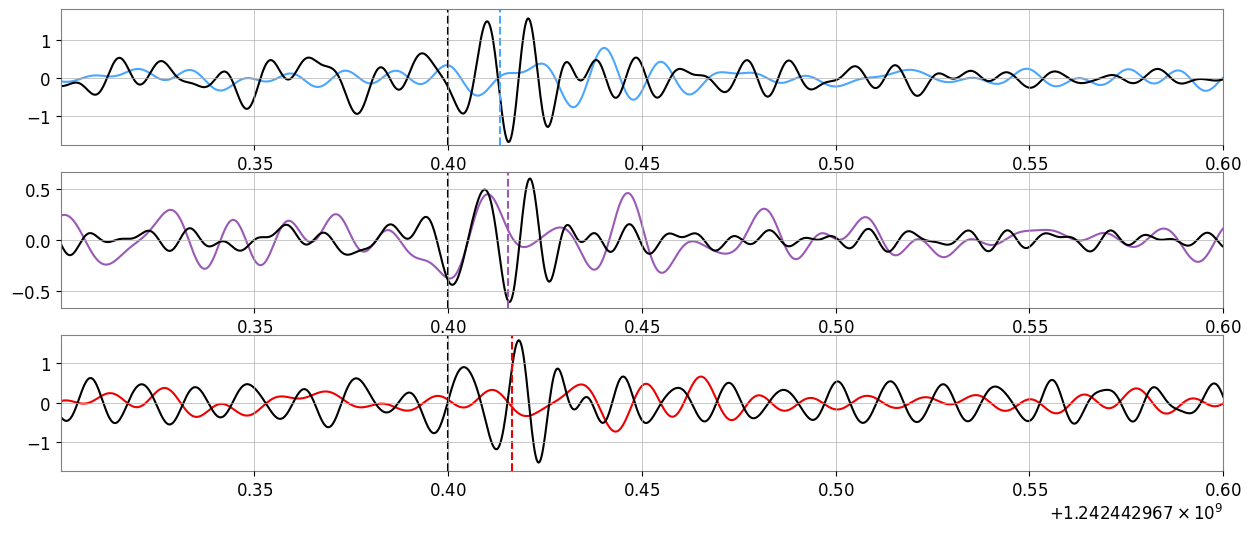

Steps	log(likelihood)
3	907.089


In [ ]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, axs = plt.subplots(len(ifos), 1, figsize=[15, 6])
Neval = 1
    
lines = {}
for ax, ifo, colour in zip(axs, ifos, colours):
    white_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=f_0)

    ax.plot(white_data[ifo].times, white_data[ifo], label=f"{ifo} Strain", color=colour)
    lines[ifo], = ax.plot(white_template.times, white_template, label="Template", color='k')
    ax.axvline(gps, linestyle="--", color='k', label="Event Peak")
    ax.axvline(gps_det[ifo], linestyle="--", color=colour, label="Local Time of Event")
    ax.set_xlim(gps-0.1,gps+0.2)
    

def callback(param_i):
    global Neval
    global line
    global fig
    
    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=f_0)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(param_i)))
    
    Neval += 1
    
res = minimize(lambda param: -loglikelihood(param), param0, callback=callback, method='powell')
plt.close()

This gives us a best fit parameter for the model. lets subtract it from the data and see wahat the residuals are 

In [ ]:
best_fit = res.x
best_fit_template = gen_template(best_fit)

In [ ]:

for i, ifo in enumerate(ifos):
    subtracted = data[ifo] - best_fit_template[ifo]

    # Plot the original data and the subtracted signal data
    for d, title in [(data[ifo], 'Original {} Data'.format(ifo)),
                 (subtracted, 'Signal Subtracted from {} Data'.format(ifo))]:

        qspecgram=d.whiten(asd=np.sqrt(psd[ifo])).q_transform(outseg=(gps - 1, gps + 1),
                                                     frange=(20, 512))
        
        plot = qspecgram.plot(figsize=[8, 4],vmin=0,vmax=300)
        ax = plot.gca()
        ax.set_title(title)
        ax.set_xscale('seconds')
        ax.set_yscale('log')
        ax.set_ylim(20, 500)
        ax.set_ylabel('Frequency [Hz]')
        ax.grid(True, axis='y', which='both')
        ax.colorbar(cmap='viridis', label='Normalized energy')

now lets calculate the prior

In [ ]:
def logprior(param):
    logp = 0
    
    m1, m2, distance, time, phase, ra, dec, inclination, polarization= param
    
    for angle in [ra, phase, polarization]:
        if angle < 0 or angle > 2*np.pi:
            return -np.inf
    if distance < 0:
        return -np.inf
    if inclination < 0 or inclination > np.pi:
        return -np.inf
    if dec < -np.pi/2 or dec > np.pi/2:
        return -np.inf
    
    logp += np.log(np.cos(dec))
    logp += 2*np.log(distance)
    logp += np.log(np.sin(inclination))
    return logp

If we find the inner product of the prior and the posterior this is the posterior. 

In [ ]:
def logposterior(param):
    logpost = logprior(param)
    if np.isfinite(logpost):
        logpost += loglikelihood(param)
    return logpost

In [ ]:
logposterior(param0)

here i cn maximise the posterior to produce a MAP, which is a best-guess at the parameters which fits to the data while also maintining what we would expect. 

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=[15, 6])
Neval = 1
    
lines = {}
for ax, ifo in zip(axs, ifos):
    hite_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)

    ax.plot(white_data[ifo].times, white_data[ifo], label="Data")
    lines[ifo], = ax.plot(white_template.times, white_template, label="Template")

    ax.set_xlim(time_center+.2, time_center+.5)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig
    
    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(posterior)")
    print('{}\t{:.3f}'.format(Neval, logposterior(param_i)))
    
    Neval += 1
    
res = minimize(lambda param: -logposterior(param), param0, callback=callback, method='powell')
plt.close()

In [ ]:
best_guess = res.x
print(best_guess)

Now lets sample the posterior. I will use `emcee` because it has a fun name. (but also because it is an affine invariant sampler so it evolves a sample of points not just a single point which makes it a bit faster to run on colab)

In [ ]:
!pip install emcee

In [ ]:
Nens = 100   # number of ensemble points

mmu = 0.     # mean of the Gaussian prior
msigma = 10. # standard deviation of the Gaussian prior

mini = np.random.normal(mmu, msigma, Nens) # initial m points

cmin = -10.  # lower range of prior
cmax = 10.   # upper range of prior

cini = np.random.uniform(cmin, cmax, Nens) # initial c points

inisamples = np.array([mini, cini]).T # initial samples

ndims = inisamples.shape[1] # number of parameters/dimensions

We will use a burn in of 500 samples to purge the initial stages of the mcmc

In [ ]:
Nburnin = 500   # number of burn-in samples
Nsamples = 500  # number of final posterior samples

In [ ]:
import emcee # import the emcee package

print('emcee version: {}'.format(emcee.__version__))

# for bookkeeping set number of likelihood calls to zero
loglikelihood.ncalls = 0

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
argslist = (data, sigma, x)

# set up the sampler
sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)


In [ ]:
# pass the initial samples and total number of samples required
t0 = time() # start time
sampler.run_mcmc(inisamples, Nsamples + Nburnin);
t1 = time()

timeemcee = (t1-t0)
print(f"Time taken to run 'emcee' is {timeemcee} seconds")

# extract the samples (removing the burn-in)
samples_emcee = sampler.get_chain(flat=True, discard=Nburnin)

In [ ]:
# plot the resulting posteriors
mpl.rcParams.update({'font.size': 16})

def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    if "truths" not in kwargs:
        kwargs["truths"] = [m, c]

    fig = corner.corner(samples, labels=[r'$m$', r'$c$'], hist_kwargs={'density': True}, **kwargs)

    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 3], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')

# make plot
plotposts(samples_emcee)

## Conclusions (15 points)
Minimum 300 words.
- Discuss your results in the context of the literature.
- Mention how your work compares with published results.
- Discuss some of the interpretation possibles of GW190521, including relevant citations from the literature, and summarising them.

In conclusion from the data I have gathered regarding the masses of the two objects, I can say with certainty that the event GW190521 is a black hole merger. No other objects could possibly have mass of the same magnitude. Aside from this so far there is very little to say... whoops

####Citations

Abbott, R., Abbott, T.D., Abraham, S., Acernese, F., Ackley, K., Adams, C., Adhikari, R.X., Adya, V.B., Affeldt, C., Agathos, M. and Agatsuma, K., 2020a. Properties and astrophysical implications of the 150 M⊙ binary black hole merger GW190521. The Astrophysical Journal Letters, 900(1), p.L13.

Abbott, R., Abbott, T.D., Abraham, S., Acernese, F., Ackley, K., Adams, C., Adhikari, R.X., Adya, V.B., Affeldt, C., Agathos, M. and Agatsuma, K., 2020b. GW190521: a binary black hole merger with a total mass of 150 M⊙. Physical review letters, 125(10), p.101102.

Graham, M.J., Ford, K.E.S., McKernan, B., Ross, N.P., Stern, D., Burdge, K., Coughlin, M., Djorgovski, S.G., Drake, A.J., Duev, D. and Kasliwal, M., 2020. Candidate electromagnetic counterpart to the binary black hole merger gravitational-wave event s190521g. Physical review letters, 124(25), p.251102.